In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, BatchNormalization, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import tensorflow_hub as hub
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLu = LeakyReLU(negative_slope=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier

2024-08-02 11:50:06.493905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 11:50:06.540879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 11:50:06.588485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 11:50:06.600618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 11:50:06.641750: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tqdm import tqdm

In [4]:
data = pd.read_csv('updated_data.csv')
data.head()

,tweet_text,retweet_count,favorite_count,followers_count,friends_count,verified,label,time_delay (min),neg_sent,pos_sent,neu_sent,comp_sent,difference,weight,ratio
0,"Reports of ""moving body"" amidst #Germanwings w...",38,15,337960,6384,1,1,1.2833,0.000,0.00,1.000,0.0000,0.0,0.0,1.000000e+00
1,BREAKING:148passengers were on board #GermanWi...,43,15,52815,293,0,1,1.5000,0.000,0.14,0.860,0.3818,1.0,1.0,1.000000e+10
2,BREAKING: #Germanwings crash victims include 7...,31,5,893549,2312,1,1,4.1333,0.278,0.00,0.722,-0.6124,-0.2,-0.2,6.666667e-01
3,BREAKING: 148 feared dead in crashed #Germanwi...,167,32,418641,1859,1,1,3.5167,0.517,0.00,0.483,-0.8176,0.0,0.0,1.000000e+00
4,Terrible news... Airbus A320 from Barcelona to...,26,1,11062,233,0,1,3.3667,0.171,0.00,0.829,-0.4767,0.0,0.0,1.000000e+00


In [27]:
data.isna().sum()

tweet_text          0
retweet_count       0
favorite_count      0
followers_count     0
friends_count       0
verified            0
label               0
time_delay (min)    0
neg_sent            0
pos_sent            0
neu_sent            0
comp_sent           0
difference          0
weight              0
ratio               0
dtype: int64

# Split data

In [6]:
text_data = data['tweet_text'].values
numerical_data = data[['retweet_count', 'followers_count', 'verified',
                           'time_delay (min)', 'neg_sent', 'pos_sent', 
                       'neu_sent', 'comp_sent', 'difference', 'ratio']].values
y = data['label']

In [7]:
# we added stratifying sampling
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(text_data, numerical_data, y, 
                                                                                       test_size=0.2, 
                                                                                       random_state=42, stratify=y)

In [8]:
# Get the shape of all the datasets
print(f'Train text: {len(X_train_text)}'), print(f'Train number: {len(X_train_num)}')
print(f'Test text: {len(X_test_text)}'), print(f'Test number:{len(X_test_num)}')
print(f'Y Training: {len(y_train)}'), print(f'Y Testing:{len(y_test)}')

Train text: 4641
Train number: 4641
Test text: 1161
Test number:1161
Y Training: 4641
Y Testing:1161


(None, None)

# Preprocessing

## Normalizing text features

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only

In [12]:
# Load ELMo from Tensorflow
elmo = hub.load("https://tfhub.dev/google/elmo/3")

In [13]:
#method to create word embeddings using ELMo 
def elmo_embeddings(text_list):
    embeddings = elmo.signatures['default'](tf.constant(text_list))['elmo']
    return embeddings

In [14]:
def process_in_batches(texts, batch_size=32):
    elmo_embed_np = []
    total_batches = (len(texts) + batch_size - 1) // batch_size  # Calculate total number of batches
    with tqdm(total=total_batches, desc='Processing Batches') as pbar:
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = elmo_embeddings(batch_texts)
            # Average the embeddings for each text
            batch_embeddings_np = [np.mean(embed.numpy(), axis=0) for embed in batch_embeddings]
            for embed in batch_embeddings_np:
                if embed.shape != (1024,):
                    print(f"Unexpected shape found: {embed.shape}")
            elmo_embed_np.extend(batch_embeddings_np)
            pbar.update(1)  # Update progress bar
    return np.array(elmo_embed_np)

In [15]:
# Process ELMo embeddings in batches
train_elmo_embed_np = process_in_batches(X_train_text, batch_size=16)  # Adjust batch size as needed
test_elmo_embed_np = process_in_batches(X_test_text, batch_size=16)  # Adjust batch size as needed

Processing Batches: 100%|███████████████████████| 73/73 [01:38<00:00,  1.34s/it]


## Normalizing Numerical features

In [16]:
#using custom range
class CustomMinMaxScaler:
    def __init__(self, feature_range=(-2, 2)):
        self.feature_range = feature_range
        self.scaler = MinMaxScaler(feature_range=(0, 1))
    
    def fit(self, X):
        # Fit the scaler to the data
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        # Transform the data to [0, 1] range
        X_normalized = self.scaler.transform(X)
        # Scale to the desired range [-2, 2]
        a, b = self.feature_range
        X_scaled = a + (X_normalized * (b - a))
        return X_scaled
    
    def fit_transform(self, X):
        # Fit and transform the data
        return self.fit(X).transform(X)

In [17]:
num_scaler = CustomMinMaxScaler(feature_range=(-2, 2))

train_norm_num_features = num_scaler.fit_transform(X_train_num)
test_norm_num_features = num_scaler.fit_transform(X_test_num)
print(f'Normalized test shape: {test_norm_num_features.shape}')

Normalized test shape: (1161, 10)


In [18]:
X_train = np.hstack((train_elmo_embed_np, train_norm_num_features))
X_test = np.hstack((test_elmo_embed_np, test_norm_num_features))

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (4641, 1034)
Test shape: (1161, 1034)


# Model

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid={
    'alpha':[0.0001, 0.001, 0.1],
    'learning_rate_init':[0.0001, 0.001, 0.1], 
    'max_iter': [100, 200, 300 , 400]
}


mlp_model = MLPClassifier(random_state=42)

grid_search = GridSearchCV(mlp_model, param_grid, cv=10, verbose=0, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=42),
             param_grid={'alpha': [0.0001, 0.001, 0.1],
                         'learning_rate_init': [0.0001, 0.001, 0.1],
                         'max_iter': [100, 200, 300, 400]},
             scoring='accuracy')

In [29]:
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'alpha': 0.1, 'learning_rate_init': 0.001, 'max_iter': 100}


In [30]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
mlp_model = MLPClassifier(alpha=0.1, learning_rate_init=0.001, max_iter=100, random_state=42) # Initialize a decision tree regressor
scoring = ['accuracy', 'recall',  'precision','f1_macro', 'f1_weighted' ]
scores = cross_validate(mlp_model, X_train, y_train, scoring=scoring, cv=10)
mlp_cv_scores = pd.DataFrame(scores)
display(mlp_cv_scores)

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_macro,test_f1_weighted
0,3.055070,0.008006,0.834409,0.727848,0.771812,0.812795,0.833177
1,3.060269,0.007754,0.866379,0.789809,0.810458,0.849838,0.865950
2,3.106655,0.007615,0.846983,0.764331,0.779221,0.828316,0.846617
3,3.148798,0.007803,0.844828,0.700637,0.814815,0.820109,0.841666
4,3.152791,0.008229,0.846983,0.753165,0.788079,0.827763,0.846115
5,3.258031,0.008376,0.866379,0.759494,0.833333,0.847830,0.864776
6,3.217280,0.008171,0.879310,0.765823,0.864286,0.861596,0.877389
7,3.253583,0.008129,0.827586,0.740506,0.750000,0.807465,0.827318
8,3.286838,0.008022,0.853448,0.740506,0.812500,0.833104,0.851690
9,3.279580,0.008360,0.834052,0.772152,0.748466,0.816636,0.834661


In [31]:
avg_f1_macro_cv_score = mlp_cv_scores['test_f1_macro'].mean()
avg_f1_weighted_cv_score = mlp_cv_scores['test_f1_weighted'].mean()
avg_precision_cv_score = mlp_cv_scores['test_precision'].mean()
avg_recall_cv_score = mlp_cv_scores['test_recall'].mean()
avg_acc_cv_score = mlp_cv_scores['test_accuracy'].mean()

acc_perc = round((avg_acc_cv_score * 100), 2)
recall_perc = round((avg_recall_cv_score * 100), 2)
precision_perc = round((avg_precision_cv_score * 100), 2)
weighted_perc = round((avg_f1_weighted_cv_score * 100), 2)
macro_perc = round((avg_f1_macro_cv_score * 100), 2)

print(f'Precision: {avg_precision_cv_score}', f'| Prec %: {precision_perc}')
print(f'Recall: {avg_recall_cv_score}', f' | Recall %: {recall_perc}')
print(f'Accuracy: {avg_acc_cv_score}', f' | Accuracy %: {acc_perc}')
print(f'Macro F1: {avg_f1_macro_cv_score}', f' | Macro F1 %: {macro_perc}')
print(f'Weighted F1: {avg_f1_weighted_cv_score}', f' | Weighted F1 %: {weighted_perc}')

Precision: 0.7972969966398811 | Prec %: 79.73
Recall: 0.751427074094977  | Recall %: 75.14
Accuracy: 0.8500356878012607  | Accuracy %: 85.0
Macro F1: 0.8305450822334146  | Macro F1 %: 83.05
Weighted F1: 0.8489359001892185  | Weighted F1 %: 84.89


In [32]:
mlp_model.fit(X_train, y_train)

MLPClassifier(alpha=0.1, max_iter=100, random_state=42)

In [34]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score,f1_score
y_test_pred = mlp_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

test_acc_perc = round((test_accuracy * 100), 2)
test_recall_perc = round((test_recall * 100), 2)
test_precision_perc = round((test_precision * 100), 2)

print(f'Test Precision: {test_precision}', f" | Test Set Accuracy %: {test_acc_perc}")
print(f'Training Set Recall: {test_recall}', f' | Test Set Recall %: {test_recall_perc}')
print(f"Training Set Accuracy: {test_accuracy}", f' | Test Set Precision %: {test_precision_perc}')

from sklearn.metrics import f1_score
macrof1_score = f1_score(y_test, y_test_pred, average='macro')
macro_perc = round((macrof1_score * 100), 2)
print(f'Macro F1: {macrof1_score}',f' | Test Macro F1 %: {macro_perc}')

wf1_score = f1_score(y_test, y_test_pred, average='weighted')
weighted_perc = round((wf1_score * 100), 2)
print(f'Weighted F1: {wf1_score}',f' | Test Weighted F1 %: {weighted_perc}')

Test Precision: 0.8073394495412844  | Test Set Accuracy %: 83.29
Training Set Recall: 0.6683544303797468  | Test Set Recall %: 66.84
Training Set Accuracy: 0.8329026701119724  | Test Set Precision %: 80.73
Macro F1: 0.8050259695290859  | Test Macro F1 %: 80.5
Weighted F1: 0.8285846390421859  | Test Weighted F1 %: 82.86


In [24]:
def mlp_model(neurons, hidden_layers, activation, learning_rate, normalization):
    mlp = Sequential()
    # Input layer with the shape of the input we defined
    mlp.add(Dense(units = neurons,activation=activation, input_dim=1034))

    # create a given amount of hidden layers
    for i in range(hidden_layers):
        mlp.add(Dense(units = neurons, activation= activation))

        if normalization > 0.5:
            mlp.add(BatchNormalization())


    # add another dense layer for output
    mlp.add(Dense(units=1, activation='sigmoid'))

    # compile the model
    mlp.compile(optimizer = Adam(learning_rate = learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall', 'Precision', 'FalseNegatives']
                 )

    return mlp

In [22]:
mlp_params={
    'neurons': [10, 20, 30, 40, 50, 60, 70, 80 ,90,100],
    'hidden_layers' : [1, 2, 3 ,4], 
    'learning_rate':[0.001, 0.1, 0.0001, 0.1], 
    'activation':['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential'],
    'epochs':[10, 15, 20, 25, 30, 35, 40, 45, 50],
    'normalization': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
    'batch_size':[16,32, 64, 128]
}

In [26]:
from sklearn.model_selection import GridSearchCV
scoring =['accuracy', 'recall', 'precision', 'f1_macro', 'f1_weighted']
model = KerasClassifier(mlp_model, verbose=0)
grid_search = GridSearchCV(estimator=model, param_grid = mlp_params, cv=10, verbose=0, scoring='accuracy')
grid_search.fit(X_train, y_train)

ValueError: Invalid parameter activation for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(activation=relu)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
xg_model = XGBClassifier(random_state=42)

param_grid = {
    'max_depth': [6, 10, 20, None]
}
grid_search = GridSearchCV(xg_model, param_grid, cv=10, verbose=0, scoring='accuracy')
grid_search.fit(X_train, y_train)

In [50]:
def mlp_ev(neurons, hidden_layers, learning_rate, activation, optimizer, epochs, normalization, batch_size):
    neurons = int(round(neurons))
    hidden_layers = int(round(hidden_layers))
    batch_size = int(round(batch_size))
    epochs = int(round(epochs))
    # Define lists and dictionaries for optimizers and activation functions
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']
    optimizerL = ['SGD','Adam','RMSprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl']
    optimizerD = {'SGD':SGD(learning_rate = learning_rate),
                  'Adam':Adam(learning_rate = learning_rate),
                  'RMSprop':RMSprop(learning_rate = learning_rate),
                  'Adadelta':Adadelta(learning_rate = learning_rate),
                  'Adagrad':Adagrad(learning_rate = learning_rate),
                  'Adamax':Adamax(learning_rate = learning_rate),
                  'Nadam':Nadam(learning_rate = learning_rate),
                  'Ftrl':Ftrl(learning_rate = learning_rate)}

    # Convert indices to corresponding names and instantiate optimizer
    activation = activationL[int(round(activation))]
    optimizer_name = optimizerL[int(round(optimizer))]
    optimizer_instance = Adam(learning_rate = learning_rate)
    
    # Define the Keras model with the provided parameters
    def create_model():
        return mlp_model(
            neurons =neurons,
            hidden_layers = hidden_layers,
            activation=activation,
            optimizer=optimizer_instance,
            learning_rate=learning_rate,
            normalization = normalization
        )
    
        # Create KerasClassifier
    model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Define early stopping
    # es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    
    # Perform cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
    
    score=np.nan_to_num(score)

    score=score.mean()
    return score

In [22]:
mlp_params={
    'neurons': [10, 20, 30, 40, 50, 60, 70, 80 ,90,100],
    'hidden_layers' : [1, 2, 3 ,4], 
    'learning_rate':[0.001, 0.1, 0.0001, 0.1], 
    'activation':['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential'],
    'epochs':[10, 15, 20, 25, 30, 35, 40, 45, 50],
    'normalization': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'batch_size':[16,32, 64, 128]
}

In [51]:
# Initialize the optimizer
mlp_bo_optimizer = BayesianOptimization(mlp_ev, mlp_params, random_state=111)

# Run the optimizer
mlp_bo_optimizer.maximize(n_iter=100)

|   iter    |  target   | activa... | batch_... |  epochs   | hidden... | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.132     | 4.285     | 34.94     | 27.44     | 3.308     | 0.03024   | 23.42     | 0.02248   | 2.942     |
| 2         | 0.1651    | 1.671     | 53.82     | 49.63     | 1.713     | 0.009038  | 70.26     | 0.6212    | 1.92      |
| 3         | 0.1475    | 3.264     | 29.26     | 12.96     | 3.702     | 0.0796    | 85.65     | 0.8152    | 6.937     |
| 4         | 0.158     | 4.041     | 107.1     | 26.85     | 1.082     | 0.04596   | 19.48     | 0.8172    | 4.884     |
| 5         | 0.1554    | 3.957     | 46.71     | 49.94     | 1.414     | 0.06193   | 53.65     | 0.405     | 5.095     |
| 6         | 0.1619    | 4.439     | 76.22     | 50.0      | 1.0       | 0.001     | 73.29     | 0.8531    | 0.0       |
| 7         | 0.132     

| 10        | 0.1621    | 4.59      | 116.6     | 38.53     | 1.432     | 0.08959   | 89.42     | 0.3752    | 2.379     |


| 11        | 0.1623    | 6.499     | 116.7     | 44.82     | 2.844     | 0.0279    | 41.81     | 0.8252    | 6.691     |
| 12        | 0.132     | 0.319     | 68.67     | 26.99     | 3.844     | 0.0861    | 60.21     | 0.3411    | 4.55      |
| 13        | 0.1634    | 0.4884    | 24.31     | 21.63     | 3.019     | 0.003187  | 18.78     | 0.3413    | 1.935     |
| 14        | 0.163     | 5.024     | 57.75     | 34.16     | 1.374     | 0.06138   | 76.27     | 0.2709    | 1.685     |
| 15        | 0.1619    | 1.683     | 42.48     | 29.24     | 1.24      | 0.005254  | 18.96     | 0.8079    | 5.473     |
| 16        | 0.132     | 1.664     | 18.18     | 26.16     | 1.798     | 0.09052   | 31.43     | 0.1924    | 3.832     |
| 17        | 0.1643    | 5.952     | 117.0     | 21.4      | 2.548     | 0.03447   | 24.26     | 0.3681    | 2.035     |
| 18        | 0.163     | 1.253     | 124.8     | 21.75     | 1.347     | 0.05375   | 44.04     | 0.1865    | 5.757     |
| 19        | 0.1643    

In [52]:
# # Print the best result
print(mlp_bo_optimizer.max)

{'target': 0.1672766415500538, 'params': {'activation': 4.563886518210809, 'batch_size': 101.99575405579732, 'epochs': 45.12217221095308, 'hidden_layers': 3.8677980602034028, 'learning_rate': 0.004698461743459623, 'neurons': 12.993169412531657, 'normalization': 0.29500046151260095, 'optimizer': 3.2407500461618106}}


In [56]:
# Extract the results
results = mlp_bo_optimizer.res
# Create a DataFrame from the results
results_df = pd.DataFrame(results)
# Optionally, save the DataFrame to a CSV file
results_df.to_csv('mlp_bayesian_optimization_results.csv', index=False)

In [55]:
import json
# Extract the best result
best_result = mlp_bo_optimizer.max

# Save the best result to a JSON file
with open('mlp_best_result.json', 'w') as f:
    json.dump(best_result, f)

# Model with optimal Parameters

In [20]:
def mlp_model_create(neurons, hidden_layers, learning_rate, activation, optimizer, epochs, normalization, batch_size):
    neurons = int(round(neurons))
    hidden_layers = int(round(hidden_layers))
    batch_size = int(round(batch_size))
    epochs = int(round(epochs))
    # Define lists and dictionaries for optimizers and activation functions
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']

    # Convert indices to corresponding names and instantiate optimizer
    activation = activationL[int(round(activation))]
    optimizer_instance = Adam(learning_rate = learning_rate)
    
    # Define the Keras model with the provided parameters
    def create_model():
        return mlp_model(
            neurons =neurons,
            hidden_layers = hidden_layers,
            activation=activation,
            optimizer=optimizer_instance,
            learning_rate=learning_rate,
            normalization = normalization
        )

    model = create_model()
    return model

In [38]:
activation_index= 4.563886518210809
batch_size = 101.99575405579732
epochs =45.12217221095308
hidden_layers= 3.8677980602034028
learning_rate=0.004698461743459623
neurons=12.993169412531657
normalization= 0.29500046151260095
optimizer=3.2407500461618106

In [40]:
neurons = int(round(neurons))
hidden_layers = int(round(hidden_layers))
batch_size = int(round(batch_size))
epochs = int(round(epochs))
# Define lists and dictionaries for optimizers and activation functions
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']

# Convert indices to corresponding names and instantiate optimizer
activation = activationL[int(round(activation_index))]
optimizer_instance = Adam(learning_rate = learning_rate)

model = mlp_model(neurons, hidden_layers, activation, optimizer_instance,learning_rate, normalization)
history = model.fit(X_train, y_train, validation_split = 0.2, batch_size = batch_size, epochs = epochs)

Epoch 1/45
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - FalseNegatives: 273.1842 - Precision: 0.6340 - accuracy: 0.7494 - loss: 0.5291 - recall: 0.5367 - val_FalseNegatives: 89.0000 - val_Precision: 0.7470 - val_accuracy: 0.8138 - val_loss: 0.4131 - val_recall: 0.7359
Epoch 2/45
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 185.0789 - Precision: 0.7328 - accuracy: 0.8168 - loss: 0.3940 - recall: 0.7315 - val_FalseNegatives: 109.0000 - val_Precision: 0.7862 - val_accuracy: 0.8159 - val_loss: 0.4110 - val_recall: 0.6766
Epoch 3/45
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 179.5526 - Precision: 0.7631 - accuracy: 0.8279 - loss: 0.3901 - recall: 0.7146 - val_FalseNegatives: 89.0000 - val_Precision: 0.7898 - val_accuracy: 0.8332 - val_loss: 0.3874 - val_recall: 0.7359
Epoch 4/45
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 146.4737 - Precision: 0.8023 - accuracy: 0.8592 - loss: 0.3206 - recall: 0.7722 - val_FalseNegatives: 80.0000 - val_Precision: 0.7908 - 

In [35]:
import matplotlib.pyplot as plt
def plot_all_metrics(history):
    metrics = ['accuracy', 'loss', 'recall', 'Precision', 'FalseNegatives']
    
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        plt.plot(history.history[metric], label='Training ' + metric)
        plt.plot(history.history['val_' + metric], label='Validation ' + metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(metric.capitalize() + ' over Epochs')
        plt.tight_layout()

    plt.show()

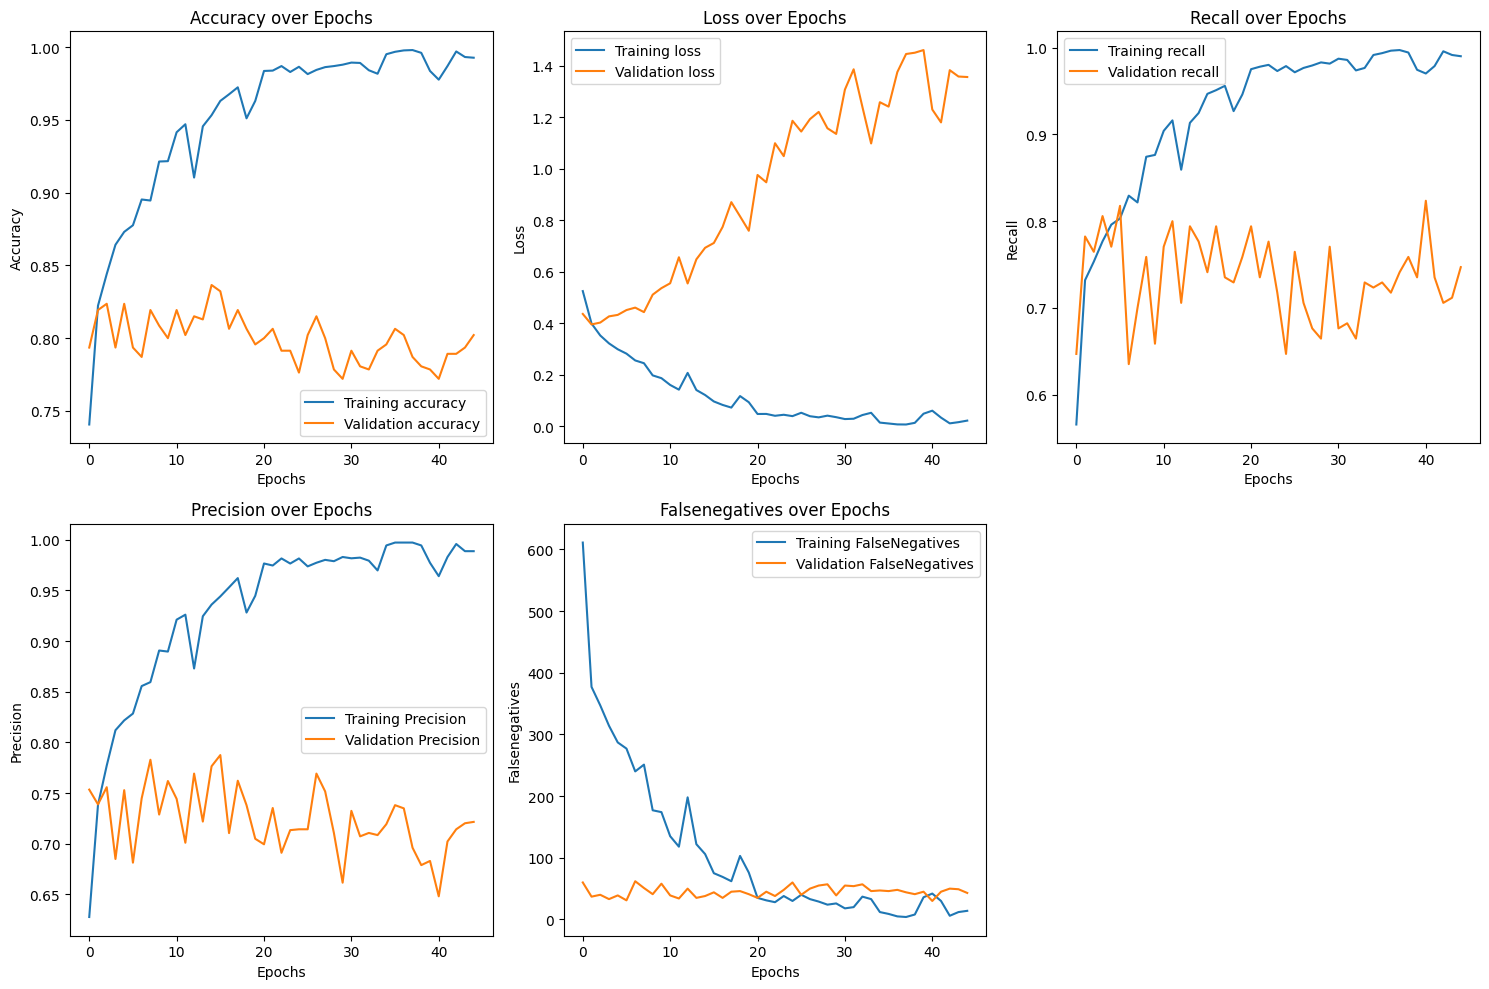

In [36]:
plot_all_metrics(history)

## Model Evaluation

In [41]:
train_evaluation_results = model.evaluate(X_train, y_train)
train_loss = train_evaluation_results[0]
train_accuracy = train_evaluation_results[1]
train_recall = train_evaluation_results[2]
train_precision = train_evaluation_results[3]
train_false_negatives = train_evaluation_results[4]

print(f'Test loss: {train_loss}')
print(f'Test accuracy: {train_accuracy}')
print(f'Test recall: {train_recall}')
print(f'Test precision: {train_precision}')
print(f'Test false negatives: {train_false_negatives}')

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - FalseNegatives: 17.2245 - Precision: 0.9921 - accuracy: 0.9918 - loss: 0.0363 - recall: 0.9833 
Test loss: 0.23471806943416595
Test accuracy: 0.959276020526886
Test recall: 0.93658846616745
Test precision: 0.9431673288345337
Test false negatives: 100.0


In [42]:
train_acc_perc = round((train_accuracy * 100), 2)
train_recall_perc = round((train_recall * 100), 2)
train_precision_perc = round((train_precision * 100), 2)

print(f"Training Set Accuracy %: {train_acc_perc}")
print(f'Training Set Recall %: {train_recall_perc}')
print(f'Training Set Precision %: {train_precision_perc}')

Training Set Accuracy %: 95.93
Training Set Recall %: 93.66
Training Set Precision %: 94.32


In [51]:
#make prediction 
train_preds = np.round(model.predict(X_train))
print('Number of predictions made by the model: {}'.format(len(train_preds)))

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
Number of predictions made by the model: 4641


In [53]:
from sklearn.metrics import f1_score
train_macrof1_score = f1_score(y_train, train_preds, average='macro')
train_macro_perc = round((train_macrof1_score * 100), 2)
print(train_macrof1_score)

print(f'Macro F1 %: {train_macro_perc}')

0.954539798310194
Macro F1 %: 95.45


In [54]:
train_wf1_score = f1_score(y_train, train_preds, average='weighted')
train_weighted_perc = round((train_wf1_score * 100), 2)
print(train_wf1_score)

print(f'Macro F1 %: {train_weighted_perc}')

0.959241239449559
Macro F1 %: 95.92


### Testing

In [43]:
evaluation_results = model.evaluate(X_test, y_test)
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]
test_recall = evaluation_results[2]
test_precision = evaluation_results[3]
test_false_negatives = evaluation_results[4]

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test recall: {test_recall}')
print(f'Test precision: {test_precision}')
print(f'Test false negatives: {test_false_negatives}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - FalseNegatives: 65.1579 - Precision: 0.7581 - accuracy: 0.8255 - loss: 0.9825 - recall: 0.6858
Test loss: 1.086877465248108
Test accuracy: 0.8234280943870544
Test recall: 0.701265811920166
Test precision: 0.7609890103340149
Test false negatives: 118.0


In [44]:
test_acc_perc = round((test_accuracy * 100), 2)
test_recall_perc = round((test_recall * 100), 2)
test_precision_perc = round((test_precision * 100), 2)

print(f"Training Set Accuracy %: {test_acc_perc}")
print(f'Training Set Recall %: {test_recall_perc}')
print(f'Training Set Precision %: {test_precision_perc}')

Training Set Accuracy %: 82.34
Training Set Recall %: 70.13
Training Set Precision %: 76.1


In [55]:
#make prediction 
test_preds = np.round(model.predict(X_test))
print('Number of predictions made by the model: {}'.format(len(test_preds)))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
Number of predictions made by the model: 1161


In [56]:
from sklearn.metrics import f1_score
test_macrof1_score = f1_score(y_test, test_preds, average='macro')
test_macro_perc = round((test_macrof1_score * 100), 2)
print(test_macrof1_score)

print(f'Macro F1 %: {test_macro_perc}')

0.799374871977726
Macro F1 %: 79.94


In [58]:
test_wf1_score = f1_score(y_test, test_preds, average='weighted')
test_weighted_perc = round((test_wf1_score * 100), 2)
print(test_wf1_score)

print(f'weighted F1 %: {test_weighted_perc}')

0.821573229925631
weighted F1 %: 82.16
